# GluonCV overview
https://gluon-cv.mxnet.io/index.html

- Image Classification
- Object detection
- Instance Segmentation
- Pose Estimation

In [1]:
!pip install gluoncv
!pip install mxnet-mkl --pre --upgrade

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: mxnet-mkl in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (1.5.0b20190701)
Requirement not upgraded as not directly required: graphviz<0.9.0,>=0.8.1 in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-mkl) (0.8.4)
Requirement not upgraded as not directly required: requests>=2.20.0 in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-mkl) (2.20.0)
Requirement not upgraded as not directly required: numpy<1.15.0,>=1.8.2 in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-mkl) (1.14.5)
Requirement not upgraded as not directly required: urllib3<1.25,>=1.21.1 in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from requests>=2.20.0->mxnet-mkl) (1.23)
Requirement not upgraded as not di

In [2]:
import warnings
warnings.filterwarnings('ignore')

import mxnet as mx
import numpy as np
import gluoncv as gcv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mxnet import nd, image
from mxnet.gluon.data.vision import transforms
from mxnet.test_utils import download
from gluoncv.model_zoo import get_model
from gluoncv.utils import viz, download

In [3]:
plt.rcParams['figure.figsize'] = (15, 9)

In [4]:
ctx = mx.cpu()

# Image Classification

With this one-line code, we can load a pre-trained **ResNet50_v1** model for classification.

In [5]:
classification_net = gcv.model_zoo.resnet50_v1b(pretrained=True, ctx=ctx)

With another one-line code we can have our prediction.

In [6]:
url = 'https://d1u4oo4rb13yy8.cloudfront.net/article/sgkvwimkyw-1532534963.jpg'
out = download(url, 'support/classification.jpg', overwrite=True)

100%|██████████| 95/95 [00:00<00:00, 35115.79KB/s]

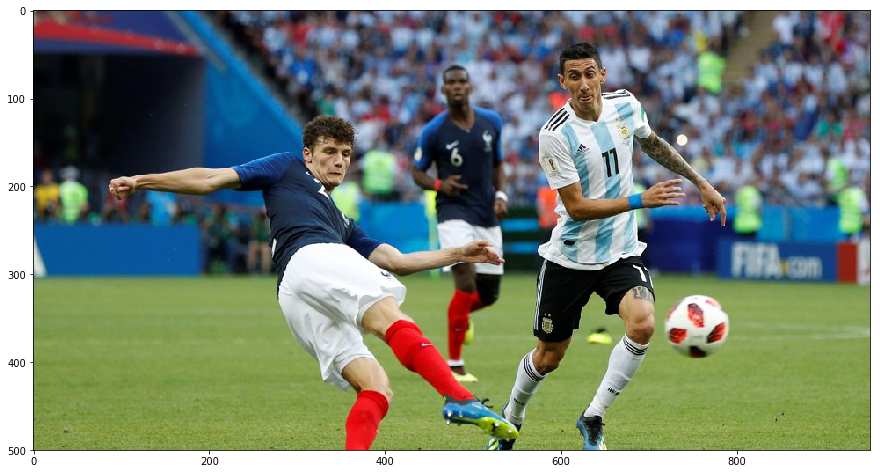

In [7]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/classification.jpg', short=500)
viz.plot_image(img)

In [8]:
%%time
pred = classification_net(x.as_in_context(ctx))
nd.waitall()

CPU times: user 1.77 s, sys: 371 ms, total: 2.14 s
Wall time: 284 ms


Let's review the top 5 prediction results.

In [9]:
topK = 5
ind = pred.topk(k=topK).astype('int')[0]
for i in range(topK):
    print('[%s], with probability %.1f%%'%
         (classification_net.classes[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()*100))

[rugby ball], with probability 2.4%
[soccer ball], with probability 1.5%
[baseball], with probability 1.1%
[ballplayer], with probability 0.9%
[football helmet], with probability 0.7%


# Object Detection

Image classifications are trained to recognize the main object in the scene. What if we have multiple subjects?

We can instead predict with an object detection model **SSD**.
![](https://cdn-images-1.medium.com/max/2000/1*pPxrkm4Urz04Ez65mwWE9Q.png)
![](https://i.stack.imgur.com/Z3cIS.png)

In [10]:
detection_net = get_model('ssd_512_resnet50_v1_coco', pretrained=True, ctx=ctx)

Now we predict. Notice we have three output variables.

In [11]:
%%time
class_IDs, scores, bounding_boxes = detection_net(x.as_in_context(ctx))
nd.waitall()

CPU times: user 1.85 s, sys: 119 ms, total: 1.97 s
Wall time: 243 ms


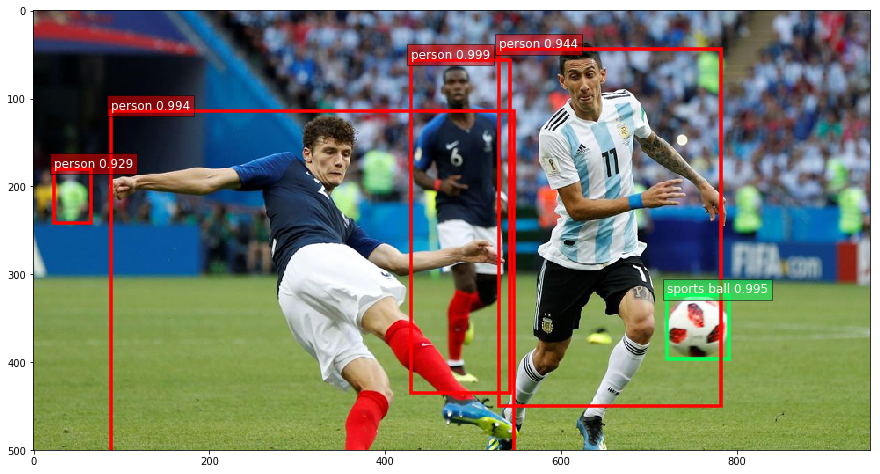

In [12]:
viz.plot_bbox(img, bounding_boxes[0], scores[0], class_IDs[0], class_names=detection_net.classes, thresh=0.8)

Can be used to count people in a picture

1296KB [00:00, 17364.89KB/s]            

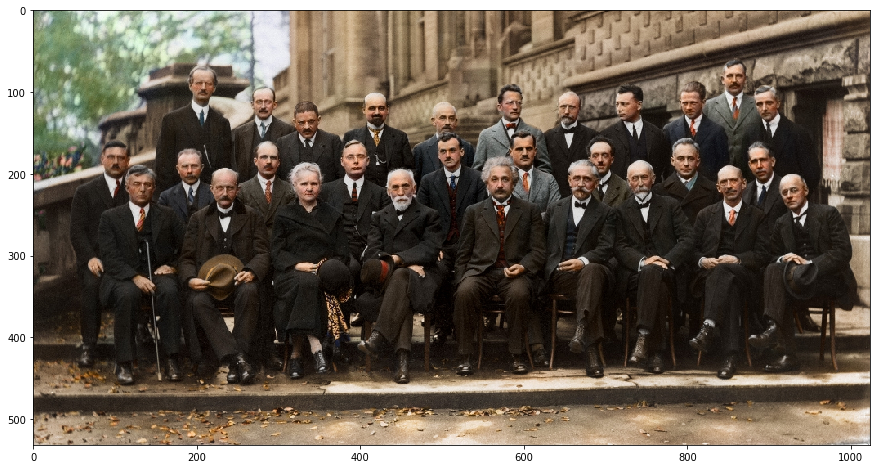

In [13]:
url = 'https://hadinur1969.files.wordpress.com/2012/09/solvay_conference_1927_crop.jpg'
download(url, 'support/detection_people.jpg', overwrite=True)
x, img = gcv.data.transforms.presets.ssd.load_test('support/detection_people.jpg', short=800)
viz.plot_image(img)

In [14]:
detection_net.reset_class(classes=['scientist'], reuse_weights={'scientist':'person'})

In [15]:
class_IDs, scores, bounding_boxes = detection_net(x.as_in_context(ctx))

There are 27 people in this photo.
Actually, it should be 29.


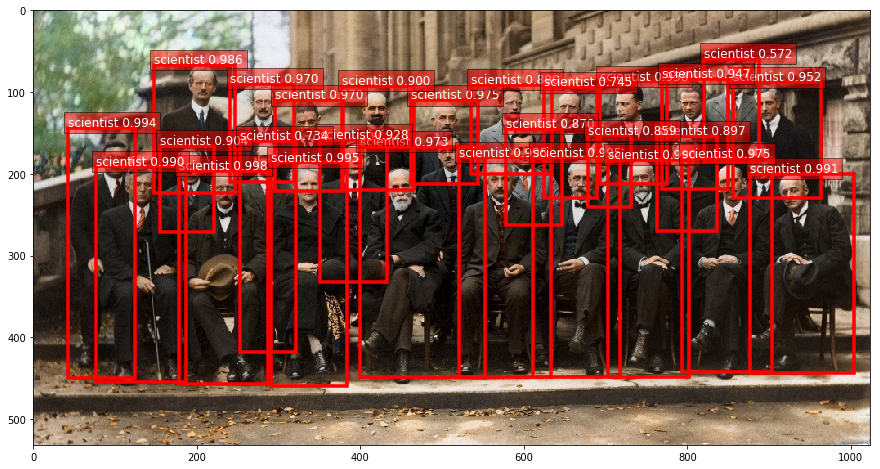

In [16]:
viz.plot_bbox(img, bounding_boxes[0], scores[0], class_IDs[0], class_names=detection_net.classes)

print('There are %d people in this photo.\nActually, it should be 29.'%int((scores>0.5).sum().asscalar()))

Another scenario, following the heating topic: automated driving.

100%|██████████| 314/314 [00:00<00:00, 7786.24KB/s]

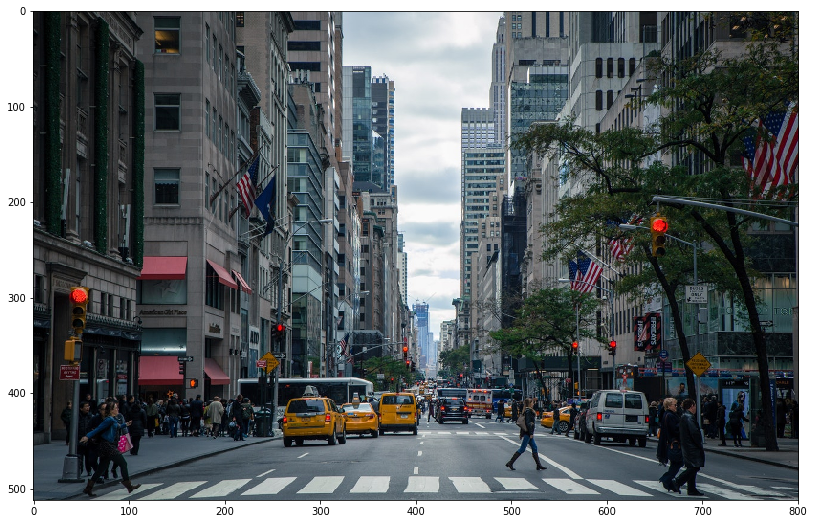

In [17]:
url = 'https://images.pexels.com/photos/378570/pexels-photo-378570.jpeg?dl&fit=crop&crop=entropy&w=1280&h=818'
download(url, 'support/detection_street.jpg', overwrite=True)
x, img = gcv.data.transforms.presets.ssd.load_test('support/detection_street.jpg', short=512)
viz.plot_image(img)

In [18]:
detection_net = get_model('ssd_512_resnet50_v1_coco', pretrained=True, ctx=ctx)

In [19]:
%%time
class_IDs, scores, bounding_boxs = detection_net(x.as_in_context(ctx))

CPU times: user 211 ms, sys: 50.5 ms, total: 262 ms
Wall time: 29.7 ms


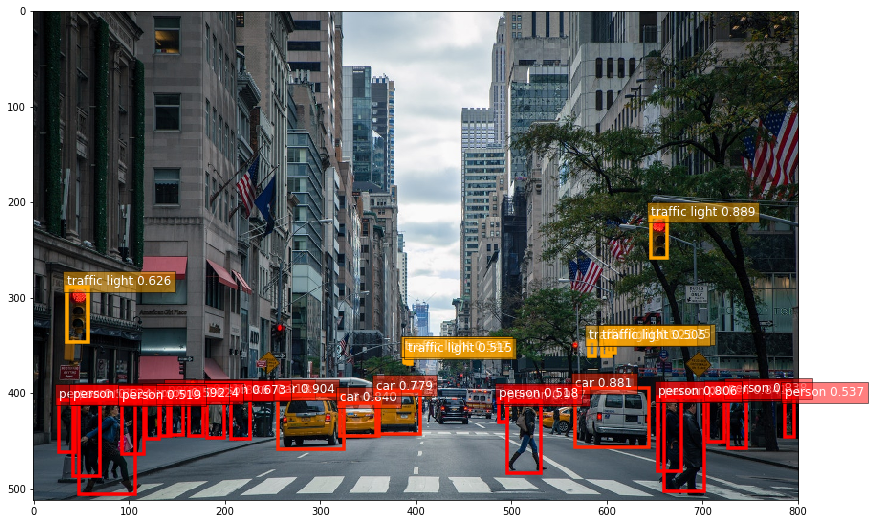

In [20]:
viz.plot_bbox(img, bounding_boxs[0], scores[0], class_IDs[0], class_names=detection_net.classes)

# Semantic Segmentation

Semantic segmentation takes the concept further, by predicting the class for every pixel.

In [21]:
segmentation_net = get_model('fcn_resnet50_ade', pretrained=True, ctx=ctx)

In [22]:
%%time
output = segmentation_net.demo(x.as_in_context(ctx))
pred = output.argmax(1).asnumpy().squeeze()

CPU times: user 8.79 s, sys: 1.02 s, total: 9.81 s
Wall time: 1.63 s


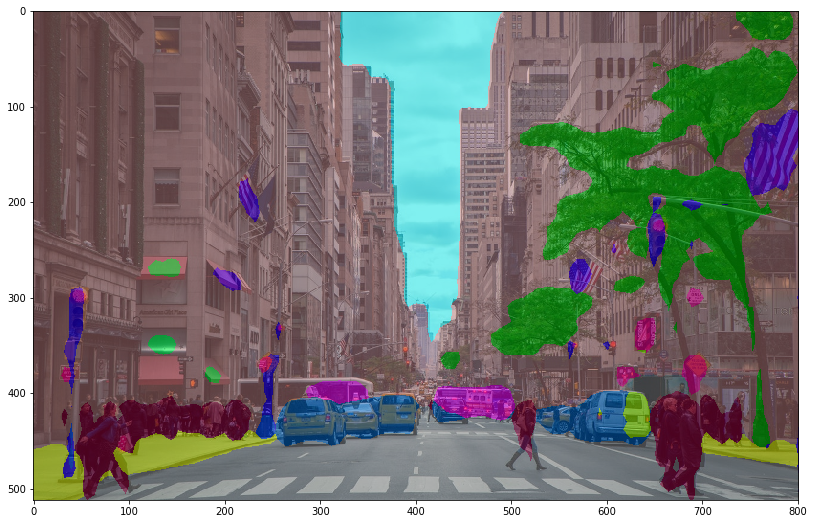

In [23]:
mask = viz.get_color_pallete(pred, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+img)/2

plt.imshow(combined.astype(np.uint8))

In [24]:
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()
instance_net = get_model('mask_rcnn_resnet50_v1b_coco', pretrained=True, ctx=ctx)

In [25]:
x, orig_img = gcv.data.transforms.presets.rcnn.load_test('support/detection_street.jpg', short=700)

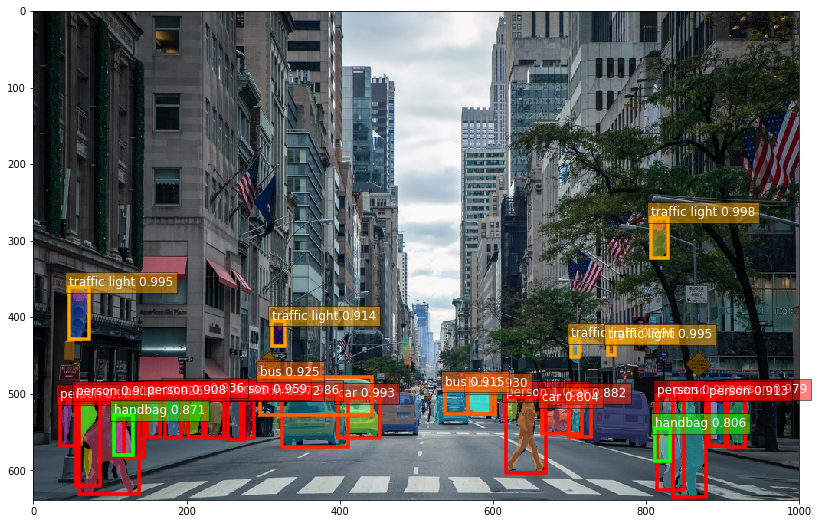

In [26]:
ids, scores, bboxes, masks = [xx[0].asnumpy() for xx in instance_net(x.as_in_context(ctx))]

# paint segmentation mask on images directly
width, height = orig_img.shape[1], orig_img.shape[0]
masks = viz.expand_mask(masks, bboxes, (width, height), scores)
orig_img = viz.plot_mask(orig_img, masks)

# identical to Faster RCNN object detection
viz.plot_bbox(orig_img, bboxes, scores, ids, class_names=instance_net.classes, thresh=0.8)

# Pose Estimation

(Available in gluon-cv 0.4.0 released next week)

For pose estimation, we have two approaches, bottom-up or top-down. 
- Top-down use a first pass to detect humans on a picture, and then run a pose-estimation algorithm on the crops. 
- Bottom-up use heuristics or neural networks approaches to create unique IDs from the detected keypoints

In [27]:
from matplotlib import pyplot as plt
from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord

In its latest release, Gluon-cv introduced implementation of the [Simple Baseline for Pose Estimation](https://arxiv.org/abs/1804.06208) paper

In [28]:
detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_net = model_zoo.get_model('simple_pose_resnet18_v1b', pretrained=True)

# Note that we can reset the classes of the detector to only include
# human, so that the NMS process is faster.

detector.reset_class(["person"], reuse_weights=['person'])

Model file is not found. Downloading.


88993KB [00:03, 27257.30KB/s]                           


Model file is not found. Downloading.


55763KB [00:02, 21073.96KB/s]                           


In [29]:
x, img = data.transforms.presets.ssd.load_test('support/detection_people.jpg', short=512)
print('Shape of pre-processed image:', x.shape)

class_IDs, scores, bounding_boxs = detector(x)

Shape of pre-processed image: (1, 3, 512, 986)


In [30]:
pose_input, upscale_bbox = detector_to_simple_pose(img, class_IDs, scores, bounding_boxs)

In [31]:
predicted_heatmap = pose_net(pose_input)
pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)

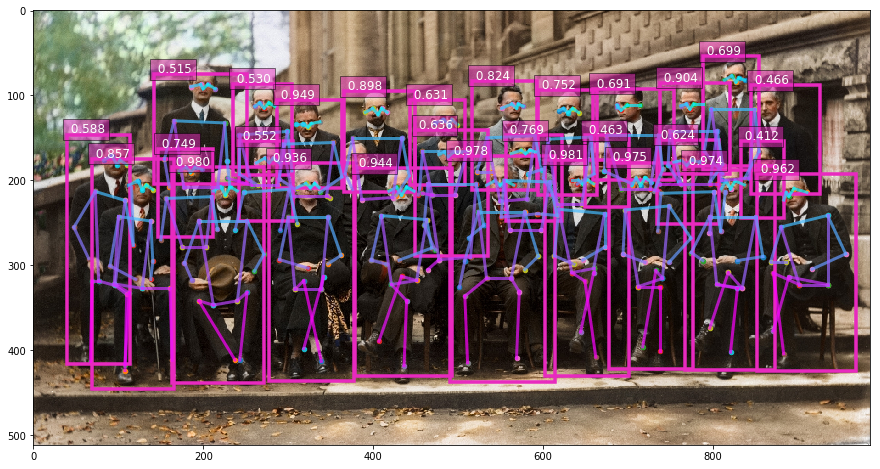

In [32]:
ax = utils.viz.plot_keypoints(img, pred_coords, confidence, class_IDs, bounding_boxs, scores, box_thresh=0.3, keypoint_thresh=0.1)